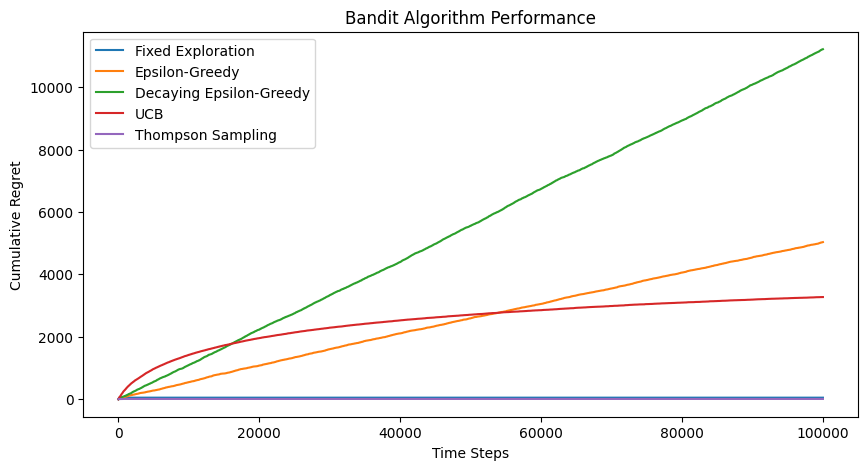

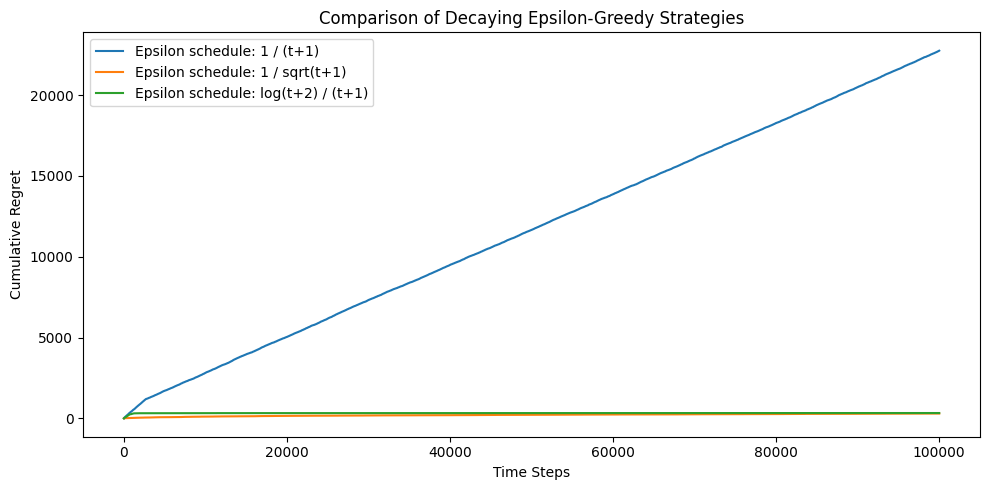

TODO: Complete the missing functions for Fixed-Exploration-Greedy, Epsilon-Greedy, Decaying Epsilon-Greedy, UCB, and Thompson Sampling.
TODO: Implement and compare different epsilon schedules (e.g., 1/t, 1/sqrt(t), log(t)/t). Discuss the impact on exploration and cumulative regret in your report.
TODO: Answer the questions in the assignment and conduct the necessary experiments to answer them.


In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Bandit Environment
class BanditEnvironment:
    def __init__(self, num_arms, reward_means):
        self.num_arms = num_arms
        self.reward_means = reward_means

    def pull_arm(self, arm):
        return np.random.binomial(1, self.reward_means[arm])  # Bernoulli rewards

# ==========================
# Fixed Exploration Then Exploitation (TODO: Implement switching strategy)
# ==========================
class FixedExplorationThenGreedy:
    def __init__(self, num_arms, exploration_steps):
        self.num_arms = num_arms
        self.exploration_steps = exploration_steps
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)
        self.t = 1

    def select_arm(self):
        if self.t <= self.exploration_steps:
            return (self.t - 1) % self.num_arms  # round-robin
        else:
            return np.argmax(self.values)

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]
        self.t += 1

# ==========================
# Epsilon-Greedy Algorithm (TODO: Complete update function)
# ==========================
class EpsilonGreedy:
    def __init__(self, num_arms, epsilon):
        self.num_arms = num_arms
        self.epsilon = epsilon
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)

    def select_arm(self):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.num_arms)
        else:
            return np.argmax(self.values)

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]

# ==========================
# Epsilon-Greedy with Decaying Exploration (TODO: Complete decay schedule and compare schedules)
# ==========================
class EpsilonGreedyDecaying:
    def __init__(self, num_arms, epsilon_schedule):
        self.num_arms = num_arms
        self.epsilon_schedule = epsilon_schedule  # Function for epsilon_t
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)
        self.t = 1

    def select_arm(self):
        epsilon_t = self.epsilon_schedule(self.t)
        if np.random.rand() < epsilon_t:
            return np.random.randint(self.num_arms)
        else:
            return np.argmax(self.values)

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]
        self.t += 1

# ==========================
# UCB Algorithm (TODO: Complete selection function)
# ==========================
class UCB:
    def __init__(self, num_arms, c):
        self.num_arms = num_arms
        self.c = c
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)
        self.t = 1

    def select_arm(self):
        if 0 in self.counts:
            return np.argmin(self.counts)  # ensure each arm is tried at least once
        ucb_values = self.values + self.c * np.sqrt(np.log(self.t) / self.counts)
        return np.argmax(ucb_values)

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]
        self.t += 1

# ==========================
# Thompson Sampling Algorithm (TODO: Implement Thompson Sampling)
# ==========================
class ThompsonSampling:
    def __init__(self, num_arms):
        self.num_arms = num_arms
        self.successes = np.zeros(num_arms)
        self.failures = np.zeros(num_arms)

    def select_arm(self):
        samples = np.random.beta(self.successes + 1, self.failures + 1)
        return np.argmax(samples)

    def update(self, arm, reward):
        if reward == 1:
            self.successes[arm] += 1
        else:
            self.failures[arm] += 1

# ==========================
# Experiment Runner
# ==========================
def run_experiment(bandit_class, bandit_params, env, num_steps):
    bandit = bandit_class(**bandit_params)
    regrets = []
    optimal_reward = max(env.reward_means)

    for t in range(num_steps):
        arm = bandit.select_arm()
        reward = env.pull_arm(arm)
        bandit.update(arm, reward)
        regret = optimal_reward - reward
        regrets.append(regret)

    return np.cumsum(regrets)

# ==========================
# Running Experiments
# ==========================
num_arms = 10
reward_means = np.linspace(0, 1, num_arms)  # Linearly spaced rewards
env = BanditEnvironment(num_arms, reward_means)
num_steps = 100000

# Define epsilon schedule
def epsilon_schedule(t):
    return 1 / (t + 1)

# Plot setup
plt.figure(figsize=(10,5))

# Run and plot Fixed Exploration Then Exploitation
fixed_exploration_regret = run_experiment(FixedExplorationThenGreedy, {'num_arms': num_arms, 'exploration_steps': 100}, env, num_steps)
plt.plot(fixed_exploration_regret, label='Fixed Exploration')

# Run and plot ε-Greedy
epsilon_greedy_regret = run_experiment(EpsilonGreedy, {'num_arms': num_arms, 'epsilon': 0.1}, env, num_steps)
plt.plot(epsilon_greedy_regret, label='Epsilon-Greedy')

# Run and plot Decaying ε-Greedy
decaying_epsilon_greedy_regret = run_experiment(EpsilonGreedyDecaying, {'num_arms': num_arms, 'epsilon_schedule': epsilon_schedule}, env, num_steps)
plt.plot(decaying_epsilon_greedy_regret, label='Decaying Epsilon-Greedy')

# Run and plot UCB
ucb_regret = run_experiment(UCB, {'num_arms': num_arms, 'c': 4}, env, num_steps)
plt.plot(ucb_regret, label='UCB')

# Run and plot Thompson Sampling
thompson_regret = run_experiment(ThompsonSampling, {'num_arms': num_arms}, env, num_steps)
plt.plot(thompson_regret, label='Thompson Sampling')

plt.xlabel("Time Steps")
plt.ylabel("Cumulative Regret")
plt.legend()
plt.title("Bandit Algorithm Performance")
plt.show()

# ==========================
# Compare Epsilon Decay Schedules in a Single Plot
# ==========================

# Define epsilon decay schedules
def schedule_1_over_t(t): return 1 / (t + 1)
def schedule_1_over_sqrt_t(t): return 1 / np.sqrt(t + 1)
def schedule_log_over_t(t): return np.log(t + 2) / (t + 1)

decay_schedules = {
    '1 / (t+1)': schedule_1_over_t,
    '1 / sqrt(t+1)': schedule_1_over_sqrt_t,
    'log(t+2) / (t+1)': schedule_log_over_t
}

plt.figure(figsize=(10, 5))

for name, schedule in decay_schedules.items():
    regret = run_experiment(
        EpsilonGreedyDecaying,
        {'num_arms': num_arms, 'epsilon_schedule': schedule},
        env,
        num_steps
    )
    plt.plot(regret, label=f'Epsilon schedule: {name}')

plt.xlabel("Time Steps")
plt.ylabel("Cumulative Regret")
plt.title("Comparison of Decaying Epsilon-Greedy Strategies")
plt.legend()
plt.tight_layout()
plt.show()

# ==========================
# Instructions for Students
# ==========================
print("TODO: Complete the missing functions for Fixed-Exploration-Greedy, Epsilon-Greedy, Decaying Epsilon-Greedy, UCB, and Thompson Sampling.")
print("TODO: Implement and compare different epsilon schedules (e.g., 1/t, 1/sqrt(t), log(t)/t). Discuss the impact on exploration and cumulative regret in your report.")
print("TODO: Answer the questions in the assignment and conduct the necessary experiments to answer them.")
